In [3]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [4]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, \
  Conv2D, BatchNormalization, ZeroPadding2D, MaxPooling2D, Activation, add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import scipy
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [5]:
# re-size all the images to this
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 20
batch_size = 128

In [6]:
!wget -nc https://lazyprogrammer.me/course_files/blood_cell_images.zip

File ‘blood_cell_images.zip’ already there; not retrieving.



In [7]:
!unzip -nq blood_cell_images.zip

In [8]:
!ls

96-accuracies-blood-cell-recognistion-with-resnet.ipynb  EfficientNetB0.ipynb
AIMIA_project_efficientNetB7.ipynb			 __MACOSX
blood_cell_images					 saved_model
blood_cell_images.zip


In [9]:
# https://www.kaggle.com/paultimothymooney/blood-cells
# train_path = '/content/drive/MyDrive/AIMIA_Project/Data/blood cell data/dataset2-master/dataset2-master/images/TRAIN'
# valid_path = '/content/drive/MyDrive/AIMIA_Project/Data/blood cell data/dataset2-master/dataset2-master/images/TEST'
# https://www.kaggle.com/paultimothymooney/blood-cells
train_path = 'blood_cell_images/TRAIN'
valid_path = 'blood_cell_images/TEST'

In [10]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [11]:
# useful for getting number of classes
folders = glob(train_path + '/*')

In [12]:
len(image_files)

9957

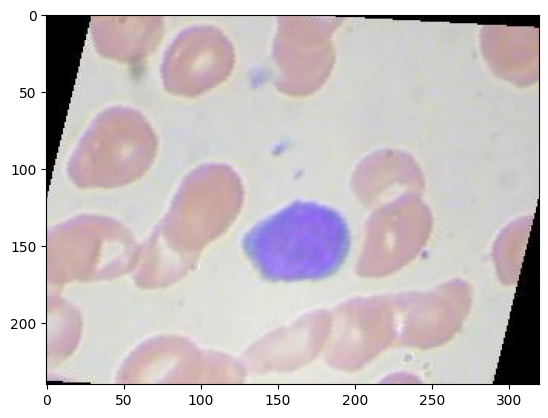

In [13]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [14]:
def identity_block(input_, kernel_size, filters):
    f1, f2, f3 = filters

    x = Conv2D(f1, (1, 1), 
               kernel_initializer='he_normal'
    )(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size, padding='same',
               kernel_initializer='he_normal'
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1), 
               kernel_initializer='he_normal'
    )(x)
    x = BatchNormalization()(x)

    x = add([x, input_])
    x = Activation('relu')(x)
    return x

In [15]:
def conv_block(input_,
               kernel_size,
               filters,
               strides=(2, 2)):
    f1, f2, f3 = filters

    x = Conv2D(f1, (1, 1), strides=strides,
               kernel_initializer='he_normal'
    )(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size, padding='same',
               kernel_initializer='he_normal'
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1),
               kernel_initializer='he_normal'
    )(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(f3, (1, 1), strides=strides,
                      kernel_initializer='he_normal'
    )(input_)
    shortcut = BatchNormalization()(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [16]:
# our custom resnet
i = Input(shape=IMAGE_SIZE + [3])
x = ZeroPadding2D(padding=(3, 3))(i)
x = Conv2D(64, (7, 7),
           strides=(2, 2),
           padding='valid',
           kernel_initializer='he_normal'
           )(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256])
x = identity_block(x, 3, [64, 64, 256])

x = conv_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])

2022-11-28 15:17:15.449368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 15:17:16.465999: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22292 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6
2022-11-28 15:17:16.467224: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22292 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:86:00.0, compute capability: 8.6


In [17]:
# our layers - you can add more if you want
x = Flatten()(x)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [18]:
# create a model object
model = Model(inputs=i, outputs=prediction)

In [19]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [20]:
# tell the model what cost and optimization method to use
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=Adam(learning_rate=0.0001),
  metrics=['accuracy']
)

In [21]:
# create an instance of ImageDataGenerator
def preprocess_input2(x):
  x /= 127.5
  x -= 1.
  return x

train_gen = ImageDataGenerator(
#   rotation_range=20,
#   width_shift_range=0.1,
#   height_shift_range=0.1,
#   shear_range=0.1,
#   zoom_range=0.2,
#   horizontal_flip=True,
#   vertical_flip=True,
  preprocessing_function=preprocess_input2,
  validation_split=0.2
)

val_gen = ImageDataGenerator(
  preprocessing_function=preprocess_input2
)

In [22]:
# train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
#     validation_split=0.2
# )

# test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
# )

In [23]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE, class_mode='sparse')
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -1.0 max: 0.99215686


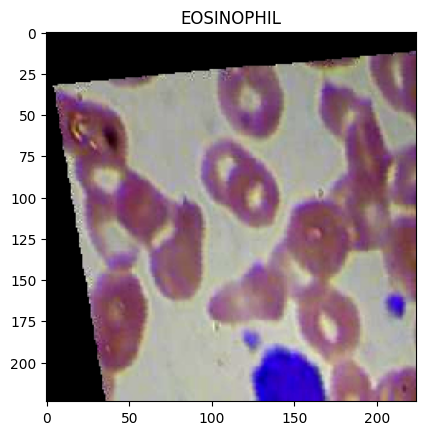

In [24]:
# should be NOT a strangely colored image
import scipy
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [25]:
# create generators
train_generator = train_gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
  subset='training'
)

valid_generator = train_gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
  subset='validation'
)

test_generator = val_gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)

Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [26]:
# fit the model
checkpoint_filepath = '/tmp/checkpoint'
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
#   steps_per_epoch=len(image_files) // batch_size,
#   validation_steps=len(valid_image_files) // batch_size,
  callbacks=[
    tf.keras.callbacks.EarlyStopping(
      monitor='loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True),
  ]
)

Epoch 1/20


2022-11-28 15:17:21.661755: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2022-11-28 15:17:22.590670: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-28 15:17:22.594118: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-11-28 15:17:22.594136: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-11-28 15:17:22.594215: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

63/63 [==============================] - 25s 307ms/step - loss: 10.8059 - accuracy: 0.3023 - val_loss: 7.9485 - val_accuracy: 0.2519
Epoch 2/20
63/63 [==============================] - 19s 294ms/step - loss: 1.1645 - accuracy: 0.6226 - val_loss: 2.1096 - val_accuracy: 0.3288
Epoch 3/20
63/63 [==============================] - 19s 296ms/step - loss: 0.4692 - accuracy: 0.8212 - val_loss: 1.6888 - val_accuracy: 0.4002
Epoch 4/20
63/63 [==============================] - 19s 293ms/step - loss: 0.1904 - accuracy: 0.9297 - val_loss: 1.4179 - val_accuracy: 0.4490
Epoch 5/20
63/63 [==============================] - 19s 294ms/step - loss: 0.0886 - accuracy: 0.9752 - val_loss: 1.3379 - val_accuracy: 0.5108
Epoch 6/20
63/63 [==============================] - 19s 296ms/step - loss: 0.0510 - accuracy: 0.9892 - val_loss: 0.6600 - val_accuracy: 0.7355
Epoch 7/20
63/63 [==============================] - 19s 296ms/step - loss: 0.0207 - accuracy: 0.9982 - val_loss: 0.5990 - val_accuracy: 0.7672
Epoch 8/2

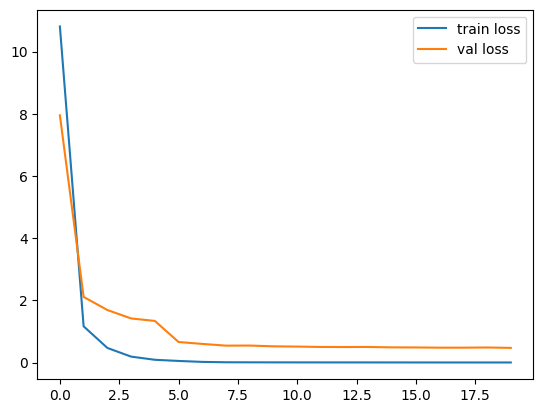

In [27]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

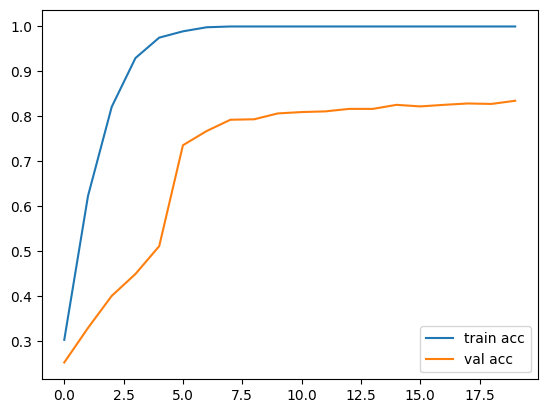

In [28]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [29]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in val_gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [30]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

Generating confusion matrix 9957
Found 9957 images belonging to 4 classes.
8/8 [==============================] - 0s 22ms/step
[[2343    6   22  126]
 [  18 2438   24    3]
 [   9    6 2444   19]
 [  88    5    3 2403]]


In [31]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 2487
Found 2487 images belonging to 4 classes.
6/6 [==============================] - 0s 23ms/step
[[310  12  22 279]
 [ 17 486  74  43]
 [ 96   2 507  15]
 [158  22   8 436]]


In [32]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[2343    6   22  126]
 [  18 2438   24    3]
 [   9    6 2444   19]
 [  88    5    3 2403]]


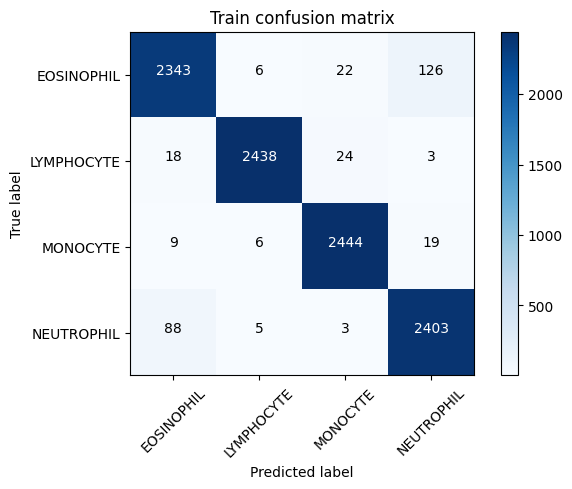

In [33]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix')

In [34]:
np.trace(cm) / cm.sum()

0.9669579190519233

Confusion matrix, without normalization
[[310  12  22 279]
 [ 17 486  74  43]
 [ 96   2 507  15]
 [158  22   8 436]]


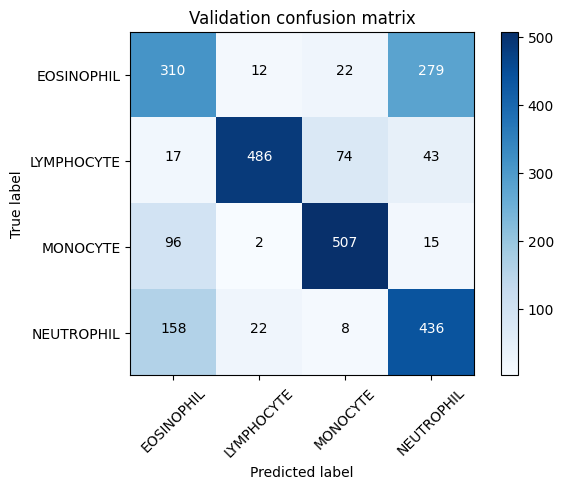

In [35]:
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

In [36]:
np.trace(valid_cm) / valid_cm.sum()

0.6992360273421794